<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/train_baseline_after_midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

필요한 패키지 불러오기

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy
!pip install transformers-interpret

matplotlib 한글 깨짐 해결

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

mecab 설치

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

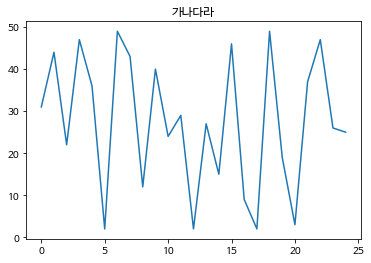

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 구글 드라이브와 코랩 연결

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기

In [ ]:
from packages import utils, tokenizer

In [ ]:
now_path = os.getcwd()
data_path = utils.recurrent_find_data_path(now_path)
bucket_files = utils.get_data_paths(data_path)
file_dict = utils.files_to_pd_dict(bucket_files)

100%|██████████| 29/29 [00:43<00:00,  1.49s/it]


In [ ]:
keys = list(file_dict.keys())
keys = keys[3:]
keys

['주거와생활',
 '식음료',
 '여가생활',
 '개인및관계',
 '미용과건강',
 '시사교육',
 '상거래(쇼핑)',
 '일과직업',
 '행사',
 '여권 최종본(0416)',
 '상수도_최종본(0416)',
 '차량등록_최종본(0429)',
 '교통_최종본(0416)',
 'A 음식점(15,726)_new',
 'B 의류(15,826)_new',
 'C 학원(4,773)_new',
 'E 생활서비스(11,087)_new',
 'G 숙박업(7,113)_new',
 'I 부동산(8,131)_new',
 'H 관광여가오락(4,949)_new',
 'D 소매점(14,949)_new',
 'F 카페(7,859)_new']

In [ ]:
tunib_train = file_dict["train"]
tunib_test = file_dict["test"]

In [ ]:
sns = ['주거와생활','식음료','여가생활','개인및관계','미용과건강','시사교육','상거래(쇼핑)','일과직업','행사']
sns_train = pd.DataFrame()
for i in sns:
  sns_train = pd.concat([sns_train, file_dict[i]], axis = 0)
sns_train = sns_train.rename(columns = {"0":"conversation"})
sns_train["class"] = "일반 대화"
print(len(sns_train))
sns_train.head()

1599992


,conversation,class
0,그럼 다른 거 살까? 눈사람 모양도 있던데\n오 그래?? 튀는거없나 이왕살거 신기한...,일반 대화
1,핸드폰 통신사 바꿀건데 사은품이 여러군데 있네.. 모기장도 있어 뭐가 좋을까?\n모...,일반 대화
2,저 커피가린부분만보이면 어디꺼인지알거같은데\n구건 알수가없어\n옹~~ㅋㅋ 무슨차인지...,일반 대화
3,신한은행이면 100만원까지 ㅋㅋㅋ 수수료 90프로 면제 신한은행 전지점에서 환전 가...,일반 대화
4,입술이나 얼른 좀 괜찮아졌음 좋겠네 ㅜㅜ 넘 아펑 ㅜㅜ\nㅜㅜ 노우우 입술은 왜케 ...,일반 대화


In [ ]:
kor1 = [ '여권 최종본(0416)','상수도_최종본(0416)',
        '차량등록_최종본(0429)','교통_최종본(0416)']
kor1_train = pd.DataFrame()
for i in kor1:
  kor1_train = pd.concat([kor1_train, file_dict[i]], axis = 0)
print(kor1_train.shape)

kor1_train = kor1_train["question"] + "\n" + kor1_train["answer"]
kor1_train.head()

(5542, 16)


0    여권 기한이 다돼가지고 새로 재발급 해야되가지고요\n아 그러세요 선생님 그런 경우는...
1    여권 시간이 좀 돼 가지고 뭐 재 발급인가 아니면 뭐 다시 해야 될 낀데 어떻게 하...
2    여권연장 발급할라 카는데요\n아 그러시다면 요즘에는 예전처럼 여권 갱신이라는 의미가...
3    여권을 갱신하고 싶은데 거 어디로 가만 되지요\n지금 대구에서는 대구시청을 방문하셔...
4                      갱신이란 건 없습니까?\n예 그렇습니다. 신규 발급인데요
dtype: object

In [ ]:
kor2 = [ 'A 음식점(15,726)_new','B 의류(15,826)_new','C 학원(4,773)_new',
        'E 생활서비스(11,087)_new','G 숙박업(7,113)_new','I 부동산(8,131)_new',
        'H 관광여가오락(4,949)_new','D 소매점(14,949)_new','F 카페(7,859)_new']
kor2_train = pd.DataFrame()
for i in kor2:
  kor2_train = pd.concat([kor2_train, file_dict[i]], axis = 0)
print(kor2_train.shape)

kor2_train = kor2_train[["SENTENCE", "SENTENCEID"]]
kor2_train = kor2_train[kor2_train["SENTENCEID"].apply(type) == int]

# 대화별로 나눈 데이터셋 가져오기
total_dataset = []
dataset = []
small_case = []
for idx, sen in tqdm(enumerate(kor2_train["SENTENCE"])):
  present = kor2_train.iloc[idx, 1]
  try:
    next = kor2_train.iloc[idx+1, 1]
  except IndexError:
    pass
  gap = present - next
  if gap < 0:
    small_case += [sen]
  else:
    small_case += [sen]
    if 5 <= len(small_case) <= 25:
      dataset += [small_case]
    small_case = []
total_dataset += dataset
total_dataset = list(map(lambda x: "\n".join(x), total_dataset))
len(total_dataset)

(90413, 19)


90395it [00:05, 15373.44it/s]


In [ ]:
kor_train = kor1_train.tolist() + total_dataset
kor_train = pd.DataFrame({"conversation": kor_train, "class":"일반 대화"})
kor_train = kor_train[kor_train["conversation"].notnull()]
kor_train = kor_train[kor_train["conversation"].apply(lambda x : len(x.split("\n")) >= 5)]
print(len(kor_train))
kor_train.head()

5117


,conversation,class
5542,지금 배달되나요?\n아 네 배달됩니다\n짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 ...,일반 대화
5543,중국집 명성루죠? 배달 지금 가능한가요?\n예 배달 가능합니다\n주로 어떤 게 잘 ...,일반 대화
5544,지금 배달 가능한가요?\n네 말씀 하세요\n네 제가 지금 전단지 보고 전화드리는 건...,일반 대화
5545,수고하십니다 죄송하지만 배달되나요?\n네\n짬뽕이나 간짜장 중에 어떤 게 잘 나가나...,일반 대화
5546,중국집 아닌가요 반점?\n예예 맞아요\n배달되나요?\n지금 끝났는데요 죄송해요\n아...,일반 대화


In [ ]:
kor_train.to_csv("../../data/TOTAL/kor_train.csv", index = False)

In [ ]:
sns_train.to_csv("../../data/TOTAL/sns_train.csv", index = False)

In [ ]:
import pandas as pd

kor_train = pd.read_csv("../../data/AI_HUB/kor_train.csv")
sns_train = pd.read_csv("../../data/AI_HUB/sns_train.csv")

In [ ]:
sns_train["split_num"] = sns_train["conversation"].apply(lambda x : len(x.split("\n")))
sns_train = sns_train[sns_train["conversation"].notnull()]
sns_train

,conversation,class,split_num
0,그럼 다른 거 살까? 눈사람 모양도 있던데\n오 그래?? 튀는거없나 이왕살거 신기한...,일반 대화,4
1,핸드폰 통신사 바꿀건데 사은품이 여러군데 있네.. 모기장도 있어 뭐가 좋을까?\n모...,일반 대화,4
2,저 커피가린부분만보이면 어디꺼인지알거같은데\n구건 알수가없어\n옹~~ㅋㅋ 무슨차인지...,일반 대화,5
3,신한은행이면 100만원까지 ㅋㅋㅋ 수수료 90프로 면제 신한은행 전지점에서 환전 가...,일반 대화,8
4,입술이나 얼른 좀 괜찮아졌음 좋겠네 ㅜㅜ 넘 아펑 ㅜㅜ\nㅜㅜ 노우우 입술은 왜케 ...,일반 대화,5
...,...,...,...
1599987,순천가서도 어디 들르기로했어?\nㅋㅋ어늘은.이게끝이야\nㅎㅎㅎ 그래 좋다 너무 늦게...,일반 대화,10
1599988,아우어도 잠깐들려서 빵사서 호텔에서 먹어도된당 성수나 청담갈라면 지나서갈듯 ㅠ\n앙...,일반 대화,6
1599989,너눈??\n나는 이제 집에가려구 버스 기다리고있어 우리 내일본다아아아아아아\n아항 ...,일반 대화,6
1599990,ㅠ.ㅠ\n현대시키몰에서 살가요 걍\n거기가 젤 싸용? 아니면 당근은요?\n우리동네는...,일반 대화,7


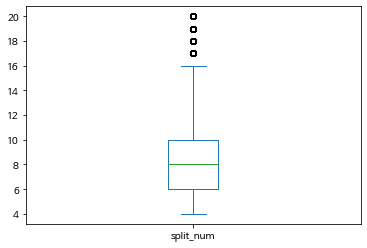

In [ ]:
sns_train["split_num"].plot(kind="box")

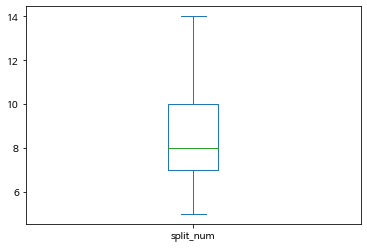

In [ ]:
sns_train = sns_train[(sns_train["split_num"] >= 5) & (sns_train["split_num"] <= 14)]
sns_train["split_num"].plot(kind="box")

In [ ]:
sns_train = sns_train[["class", "conversation"]]
len(sns_train)

1385667

In [ ]:
# sns_subset = sns_train.sample(n = len(kor_train), random_state = 6)
# len(sns_subset)

5117

In [ ]:
aihub_train = pd.concat([kor_train, sns_train], axis = 0)
len(aihub_train)

1390784

In [ ]:
aihub_train

,conversation,class
0,지금 배달되나요?\n아 네 배달됩니다\n짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 ...,일반 대화
1,중국집 명성루죠? 배달 지금 가능한가요?\n예 배달 가능합니다\n주로 어떤 게 잘 ...,일반 대화
2,지금 배달 가능한가요?\n네 말씀 하세요\n네 제가 지금 전단지 보고 전화드리는 건...,일반 대화
3,수고하십니다 죄송하지만 배달되나요?\n네\n짬뽕이나 간짜장 중에 어떤 게 잘 나가나...,일반 대화
4,중국집 아닌가요 반점?\n예예 맞아요\n배달되나요?\n지금 끝났는데요 죄송해요\n아...,일반 대화
...,...,...
1599987,순천가서도 어디 들르기로했어?\nㅋㅋ어늘은.이게끝이야\nㅎㅎㅎ 그래 좋다 너무 늦게...,일반 대화
1599988,아우어도 잠깐들려서 빵사서 호텔에서 먹어도된당 성수나 청담갈라면 지나서갈듯 ㅠ\n앙...,일반 대화
1599989,너눈??\n나는 이제 집에가려구 버스 기다리고있어 우리 내일본다아아아아아아\n아항 ...,일반 대화
1599990,ㅠ.ㅠ\n현대시키몰에서 살가요 걍\n거기가 젤 싸용? 아니면 당근은요?\n우리동네는...,일반 대화


In [ ]:
tunib_train = pd.read_csv("../../data/TUNiB/train.csv", index_col = [0])
tunib_train["split_num"] = tunib_train["conversation"].apply(lambda x : len(x.split("\n")))
tunib_train

,class,conversation,split_num
idx,,,
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,10
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,10
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,10
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,11
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,12
...,...,...,...
3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,11
3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,10
3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,11


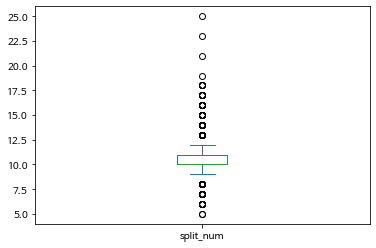

In [ ]:
tunib_train["split_num"].plot(kind="box")

In [ ]:
tunib_train[tunib_train["split_num"] == 25]

,class,conversation,split_num
idx,,,
2580,기타 괴롭힘 대화,상진아 형이 이번에 부업 하나 하려고 하는데 좀 도와줄래?\n어떤일인데요? 형?\n...,25


In [ ]:
tunib_train[tunib_train["split_num"] == 5]

,class,conversation,split_num
idx,,,
1002,협박 대화,이거 싸이코 새끼였네 너 돌았냐!!!! 사람 죽일일 있어?? 너 이새끼 깜빵 쳐가자...,5
1514,기타 괴롭힘 대화,당신 어디부서야 사장나오라그래\n고객님 죄송합니다. 이건 제 선에서는.처리가 안되는...,5


In [ ]:
tunib_train = tunib_train[["class", "conversation"]]
len(tunib_train)

3950

In [ ]:
train = pd.concat([tunib_train, aihub_train], axis = 0)
print(len(train))
train.head()

1394734


,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [ ]:
import re

def label2id(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == "협박 대화":
    return 0
  elif x == "갈취 대화":
    return 1
  elif x == "직장 내 괴롭힘 대화":
    return 2
  elif x == "기타 괴롭힘 대화":
    return 3
  elif x == "일반 대화":
    return 4

def preprocessing(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9?!,.]", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

In [ ]:
from tqdm import tqdm

train["class"] = train["class"].apply(label2id)
tqdm.pandas()
train["conversation"] = train["conversation"].progress_apply(preprocessing)
train = train.reset_index(drop=True)
train.head()

100%|██████████| 1394734/1394734 [00:30<00:00, 46221.42it/s]


,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [ ]:
train = train.sample(frac = 1).reset_index(drop=True)
train

,class,conversation
0,4,유미의세포들 존잼 이제 보는거가!! 핵잼ㅋㅋㅋㅋ 응응 오늘 정주행한다 지금?? ㅇㅇ...
1,4,먹으라고 집에가서 했대 먹자나 ㅋㅋ 그니까요 그래서걍 네 했대요 아니진짜 오지랍 장...
2,4,ㅋㅋㅋㅋㅋㅋ 인간들 정말 술값아깝게 ㅋㅋㅋㅋ 그러게 말이여 오늘은 업무 많아? 앞으...
3,4,글애서 ㅇㄷ감 ㅋㅋㅋㅋㅋ 쟤 누구냐 몰러 멀랑 존잘 내스탈 만나긴함? ㅋㅋㅋㅋㅋㅋㅋ...
4,4,졸귀 시스템 사진 돼지고양이 몸이 왜저렇게 코 커 귀염둥쓰 더워서 마루에 누워있음 ...
...,...,...
1394729,4,흠 언니가 담주월욜에 킥보드타고 너네집방문할까 그때 보면될듯 ㅋㄱㅋㄱㅋ 울집까지 오...
1394730,4,그만만둘어 그자리에 나서서 받게 기타 아 레디백 플미 오지지않음? 그거 남대문엨ㅋㅋ...
1394731,4,미란이 간은 에릭한테 물어봐야된대ㅋㅋㅋㅋㅋㅋ 거기도 간 찾니...? 어 고래가 간경...
1394732,4,ㅋㅋㅋ낼부터다시또 힘내서하믄대지... 이모티콘 운동해야대여 후 좌절좌덜 담주도 암바...


In [ ]:
train.to_csv("../../data/total.csv")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from konlpy.tag import Mecab

mecab = Mecab()

def token(x):
  return mecab.morphs(x)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# https://yanoo.tistory.com/21
# https://arxiv.org/pdf/2105.07623.pdf
tfidf_vectorizer = TfidfVectorizer(tokenizer = token)
tfidf_matrix = tfidf_vectorizer.fit_transform(train["conversation"][:10])

In [ ]:
tfidf_matrix.toarray()

In [ ]:
train.to_csv("../../data/sample_all.csv")

## 모델 클래스 및 함수 

#### 데이터 로딩 클래스

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

class DataLoad():


  def __init__(self, data_path):
    self.dataset = pd.read_csv(data_path)


  def split(self, split_size):
    X = self.dataset["conversation"]
    Y = self.dataset["class"]
    print(self.dataset.groupby("class").count().iloc[:,0])
    print(self.dataset.head())
    # 전체 데이터의 split_size 비율 만큼은 테스트, 검증 데이터입니다.
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = split_size, 
                                                            random_state = 200,
                                                            stratify = Y)
    # 테스트, 검증 데이터의 개수는 1:1의 비율을 가집니다.
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
    print(f"x_train 개수 : {len(x_train)}")
    print(f"y_train 개수 : {len(y_train)}")
    print(f"x_val 개수 : {len(x_val)}")
    print(f"y_val 개수 : {len(y_val)}")
    print(f"x_test 개수 : {len(x_test)}")
    print(f"y_test 개수 : {len(y_test)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
    print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
    print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")
    return x_train.tolist(), x_val.tolist(), x_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()

#### 데이터 증강 클래스

In [ ]:
import random
import gensim
from konlpy.tag import Mecab
from tqdm import tqdm

class DataAugmentation:


  def __init__(self, X, Y, word2vec_path):
    self.mecab = Mecab()
    self.word2vec = gensim.models.Word2Vec.load(word2vec_path)
    self.X = X
    self.Y = Y
  
  def sub_rep(self, X, sub_ratio = 0.1):
    # 전체 단어중에서 sub_ratio 만큼만 무작위 선택합니다.
    nouns = list(set(self.mecab.morphs(X)))
    sub_num = int(len(nouns) * sub_ratio)
    sub_list = random.sample(nouns, sub_num)

    # 대체 시킬 단어와 유사한 단어들을 불러옵니다.
    result = []
    for sub in sub_list:
      try:
        result.append((sub, self.word2vec.wv.most_similar(sub)[0]))
      except KeyError:
        pass
    result = list(map(lambda x: (x[0], x[1][0]), result))

    # 무작위 선택된 단어들을 유사한 단어들로 바꿔줍니다.
    for before, after in result:
      X = X.replace(before, after, 1)
    return X

  def sub_rep_dataset(self, sub_ratio = 0.1):
    # 입력 X에 sub_rep 함수 적용합니다.
    new_x = list(tqdm(map(lambda x: self.sub_rep(x, sub_ratio), self.X)))
    # 입력 Y의 값을 복사합니다.
    new_y = self.Y.copy()

    print("훈련 데이터 유의어 대체 증강 완료")
    print(f"증강시킨 데이터 개수 : {len(new_x)}")
    print(f"----데이터 증강 전 데이터 예시 ----\n{self.X[0]}")
    print(f"----데이터 증강 후 데이터 예시 ----\n{new_x[0]}")
    return new_x, new_y

  def label_repeat(self, label_id, num = 1):
    # 특정 레이블 label_id를 num 횟수 만큼 반복
    new_x = []
    new_y = []
    for i in range(num):
      label_index = (np.array(self.Y) == label_id)
      new_x += np.array(self.X)[label_index].tolist()
      new_y += np.array(self.Y)[label_index].tolist()
    
    print("훈련 데이터 특정 레이블 반복 증강 완료")
    print(f"반복되는 레이블 id : {label_id}")
    print(f"반복된 횟수 : {num}")
    return new_x, new_y

#### 기타 함수 

In [ ]:
def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"


def clf_score(y_test, y_pred):
  # 테스트 데이터에서 오분류된 데이터들의 idx를 리스트 타입으로 반환합니다.
  # classification report 
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  print(f"모델이 틀린 데이터 개수 {len(false_list)}개")
  print(classification_report(y_test, y_pred))

  # confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
  conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
  sns.heatmap(conf_matrix, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("pred")
  plt.ylabel("true")
  plt.show()
  return false_list


def evaluate_result(score_list, x_test, y_pred, y_test):
  # 입력, 예측값, 실제값, 레이블별 score로 이루어진 판다스 데이터셋을 반환합니다.
  score_dataset = pd.DataFrame(score_list).add_prefix("label_")
  label_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_test":y_test})
  test_dataset = pd.concat([label_dataset, score_dataset], axis = 1)
  return test_dataset


def false_case_dataset(false_list, x_test, y_test, y_pred, print_example = False):
  # 오분류된 idx에 맞는 입력, 예측값, 실제값을 담은 리스트를 반환합니다.
  false_x_test = [x_test[i] for i in false_list]
  false_y_test = [y_test[i] for i in false_list]
  false_y_pred = [y_pred[i] for i in false_list]

  # 앞서 담은 리스트들을 판다스 데이터프레임 타입으로 변환시킵니다.
  false_dataset = pd.DataFrame({"text":false_x_test, "y_true":false_y_test, "y_pred":false_y_pred})
  # 숫자로된 id를 실제 레이블로 바꾸며 예시는 '0 -> 협박 대화' 입니다.
  false_dataset["y_true"] = false_dataset["y_true"].apply(lambda x : id2label(x))
  false_dataset["y_pred"] = false_dataset["y_pred"].apply(lambda x : id2label(x))

  # 오분류 예제의 내용을 보고 싶으면 print_example argument를 True로 바꿉니다.
  if print_example:
    for i in range(len(false_dataset)):
      sentence, prediction, real =false_dataset.iloc[i, :]
      print(f"예측 분류 : {prediction}")
      print(f"실제 분류 : {real}")
      print(sentence)
      print("\n")
  return false_dataset  


def save_csv(df, path, name):
  try:
    os.mkdir(path)
  except:
    pass
  new_path = os.path.join(path, name)
  df.to_csv(new_path)


def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * 0.2

#### Huggingface 모델 파이프라인 클래스

In [ ]:
import os
import re
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel


class TFGPT2ForSequenceClassification(tf.keras.Model):
  """
  GPT모델은 따로 출력층에 softmax 레이어를 추가해야 합니다.
  """
  def __init__(self, model_name, num_labels):
      super(TFGPT2ForSequenceClassification, self).__init__()
      self.gpt = TFAutoModel.from_pretrained(model_name, 
                                              from_pt=True)
      self.classifier = tf.keras.layers.Dense(num_labels,
                                              kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                              activation='softmax',
                                              name='classifier')

  def call(self, inputs):
      outputs = self.gpt(input_ids=inputs)
      cls_token = outputs[0][:, -1]
      prediction = self.classifier(cls_token)

      return prediction


class TrainPipeline:
  def __init__(self, model_path, num_labels, batch_size = 16, epochs = 1):
    """
    Args:
      - model_path : Hugginface에서 사전학습된 모델들의 주소 str값을 받습니다.
      - num_labels : 분류되는 클래스의 개수 int값을 받습니다.
      - batch_size : 배치마다 들어가는 데이터의 개수 int값을 받습니다.
      - epochs : 모델이 학습하는 에폭 수 int값을 받습니다.
    Desc:
      - 데이터셋 구축, 모델 훈련, 저장, 검증의 과정을 거치는 훈련 파이프라인
    """
    self.model_path = model_path
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_labels = num_labels
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_path,
                                                   bos_token='</s>', 
                                                   eos_token='</s>', 
                                                   pad_token='<pad>')
    self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                      num_labels = self.num_labels,
                                                                      from_pt=True)
    # https://stackoverflow.com/questions/69191305/how-to-add-new-special-token-to-the-tokenizer
    # 추가된 토큰에 맞게 vocab_size 재지정
    self.model.resize_token_embeddings(len(self.tokenizer))

  def dataset(self, X, Y, lstm = False):
    """
    Args:
      - X : 모델의 입력 변수로 str문장들로 구성된 list를 받습니다.
      - Y : 모델의 출력 변수로 id값으로 구성된 list를 받습니다.
      - lstm : lstm모델 여부를 결정하는 arg로 boolean을 받습니다.
    Desc:
      - 모델 학습에 들어가기 직전의 데이터셋으로 변환시켜주는 메소드입니다.
    Returns:
      - 모델이 GPT이면 (2D-array, 1D-array) 형태의 튜플을 반환합니다.
      - 모델이 BERT, LSTM이면 텐서플로우 데이터셋을 반환합니다.
    """
    # GPT 모델인 경우 넘파이로 반환시킵니다.
    if "GPT" in str(self.model):
      # 입력 변수 X의 원소에 차례대로 토큰화를 시키고 list에 넣습니다.
      input_ids, data_labels = [], []
      for example, label in tqdm(zip(X, Y), total=len(X)):
          bos_token = [self.tokenizer.bos_token]
          eos_token = [self.tokenizer.eos_token]
          tokens = bos_token + self.tokenizer.tokenize(example) + eos_token
          input_id = self.tokenizer.convert_tokens_to_ids(tokens)
          input_ids.append(input_id)
          data_labels.append(label)

      # X에 토큰화된 문장중에서 가장 긴 문장을 기준으로 패딩을 해줍니다.
      max_seq_len = max(map(lambda x : len(x), input_ids))
      input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                                value = self.tokenizer.pad_token_id, 
                                padding='post')
      data_labels = np.array(data_labels)
      return input_ids, data_labels

    # BERT 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    if not lstm:
      encodings = self.tokenizer(X, truncation = True, padding = True)
      dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), 
                                                          Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # LSTM 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    else:
      encodings = X
      dataset = tf.data.Dataset.from_tensor_slices((encodings, 
                                                    Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset    

  def training_dataset(self, train_dataset, val_dataset):
    """
    Args:
      - train_dataset : dataset 메소드를 거친 훈련 데이터셋을 받습니다.
      - val_dataset : dataset 메소드를 거친 검증 데이터셋을 받습니다.
    Desc:
      - 호출시킨 모델에 맞게 학습을 시키고 학습된 모델을 반환시켜줍니다.
    Returns:
      - 모델이 GPT면 학습된 subclass 모델을 반환합니다
      - 모델이 LSTM, BERT이면 학습된 functional 모델을 반환합니다.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='auto', 
                                          patience=1)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    # 모델이 GPT인 경우 앞서 선언된 subclass 모델을 가져와서 학습시킵니다.
    if "GPT" in str(self.model):
      x_train, y_train = train_dataset
      x_val, y_val = val_dataset
      num_labels = int(max(y_train) + 1)
      self.model = TFGPT2ForSequenceClassification(self.model_path,
                                              num_labels = num_labels)
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(x_train, y_train,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     validation_data = (x_val, y_val),
                     callbacks = [lr_schedule, es])
      return self.model

    # 모델이 LSTM, BERT인 경우 바로 학습시킵니다.
    else:
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(train_dataset,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     validation_data = val_dataset,
                     callbacks = [lr_schedule, es])
      return self.model 

  def evaluate_model(self, x_test):
    """
    Args:
      - x_test : LSTM, GPT모델이면 2-D array의 테스트 데이터를 받습니다.
    Desc:
      - 학습된 모델에 x_test를 예측한 점수와 클래스를 반환합니다.
    Returns:
      - LSTM, GPT 모델이면 (예측 점수 list, 클래스 1D-array)인 튜플을 반환합니다.
      - BERT 모델인 경우 (예측 점수 list, 클래스 list)인 튜플을 반환합니다.
    """
    predicted_label_list = []
    predicted_score_list = []
    
    # 테스트 데이터를 예측하는 모델이 LSTM 또는 GPT인 경우
    if "Functional" in str(self.model) or "GPT" in str(self.model):
      predicted_score_list = self.model.predict(x_test)
      y_pred = np.argmax(predicted_score_list, axis = -1)
      predicted_score_list = predicted_score_list.tolist()
    
    # 테스트 데이터를 예측하는 모델이 BERT인 경우
    else:
      clf_model = TextClassificationPipeline(
          tokenizer = self.tokenizer,
          model = self.model,
          framework = "tf",
          return_all_scores = True
          )
      for text in tqdm(x_test):
          preds_list = clf_model(text)[0]
          sorted_preds_list = max(preds_list, key=lambda x: x['score'])
          predicted_label_list.append(sorted_preds_list["label"]) # label
          predicted_score_list.append(list(map(lambda x : x['score'], preds_list))) # score
      y_pred = [int(label[-1]) for label in predicted_label_list]
    return predicted_score_list, y_pred
  
  def save_model_tokenizer(self, save_path):
    """
    Args:
      - save_path : 학습된 모델을 저장할 경로인 str를 받습니다.
    Desc:
      - save_path 경로에 폴더를 만들고 학습된 모델을 저장합니다.
    """

    # save_path에 맞는 새로운 경로를 만듭니다.
    try:
      os.mkdir(save_path)
    except:
      pass
    
    # 저장하는 모델이 GPT인 경우
    if "GPT" in str(self.model):
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)
      self.model.save_weights('path_to_my_weights', save_format='tf')

    # 저장하는 모델이 LSTM인 경우
    elif "Functional" in str(self.model):
      new_path = os.path.join(save_path, "LSTM.h5", )
      self.model.save(new_path)
    
    # 저장하는 모델이 BERT인 경우
    else:
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)    
      self.model.save_pretrained(new_path)
      self.tokenizer.save_pretrained(new_path)

## Main Huggingface 함수

- "klue/bert-base"
- "skt/kogpt2-base-v2"
- "monologg/koelectra-base-v3-discriminator"
- "klue/roberta-base"
- "distilbert-base-multilingual-cased"

In [ ]:
# Huggingface에서 사용 가능한 사전학습 모델 리스트입니다.
model_paths = ["klue/bert-base"]     

# 변동 가능한 arguments로 save_path의 예시 : save_path = "./model/sample"
save_path = "./model/midterm" # 모델이 저장되는 위치
data_path = "../../data/sample_all.csv" # 학습 데이터 위치
word2vec_path = "../packages/ko.bin" # 사전 학습 임베딩 벡터 저장 위치
batch_size = 4 # 모델에 들어가는 배치 크기
epochs = 5 # 에폭 수


for model_path in model_paths:
  # TPU 작동을 위한 코드
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  with strategy.scope():
    print(f"{model_path} 파이프라인 시작")

    # 데이터 로딩
    load = DataLoad(data_path)
    x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
    test_text = x_test.copy()
    num_labels = int(max(y_train) + 1)

    # # 데이터 증강
    # data_aug = DataAugmentation(x_train, y_train, word2vec_path)
    # # 데이터 증강 : 유의어 대체
    # sub_rep_x, sub_rep_y = data_aug.sub_rep_dataset(sub_ratio = 0.1)
    # # 데이터 증강 : 같은 레이블 반복
    # repeat_x, repeat_y = data_aug.label_repeat(label_id = 3)
    # # 증강된 데이터들 합치기
    # x_train = x_train + sub_rep_x + repeat_x
    # y_train = y_train + sub_rep_y + repeat_y

    # 데이터셋 구축
    pipeline = TrainPipeline(model_path, num_labels, batch_size, epochs)
    train_dataset = pipeline.dataset(x_train, y_train)
    val_dataset = pipeline.dataset(x_val, y_val)
    if "GPT" in str(pipeline.model):
      test_dataset = pipeline.dataset(x_test, y_test)
      x_test, y_test = test_dataset

    # 모델 학습, 예측, 저장
    model = pipeline.training_dataset(train_dataset, val_dataset)
    # score_list, y_pred = pipeline.evaluate_model(x_test)
    # pipeline.save_model_tokenizer(save_path)

    # 모델 검증    
    # false_list = clf_score(y_test, y_pred)
    # false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
    # eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test)
    # save_dataset_path = os.path.join(save_path, "eval_result")
    # model_name = model_path.split("/")[-1]
    # save_csv(eval_dataset, save_dataset_path, f"{model_name}.csv")
    
    print(f"{model_path} 파이프라인 종료\n")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.97.95.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.95.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


klue/bert-base 파이프라인 시작
class
0        896
1        981
2        979
3       1094
4    1605109
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  class                                       conversation
0           0      0  지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1           1      0  길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2           2      3  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3           3      1  어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4           4      1  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
x_train 개수 : 1448153
y_train 개수 : 1448153
x_val 개수 : 80453
y_val 개수 : 80453
x_test 개수 : 80453
y_test 개수 : 80453
훈련 데이터 레이블 비율 확인 : Counter({4: 1444598, 3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({4: 80255, 3: 55, 2: 49, 1: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({4: 80256, 3: 54, 1: 49, 2: 49, 0: 45})


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task 

## 앙상블 Soft voting

In [ ]:
import pandas as pd
from collections import defaultdict
from glob import glob

def load_result_df(save_path_2):
  csv_dic = defaultdict()
  path_list = glob(save_path_2 + "/eval_result/*")
  key_list = []
  for path in path_list:
    key = path.split("/")[-1]
    key_list.append(key)
    csv_dic[key] = pd.read_csv(path)
  csv_dic = dict(csv_dic)
  print(f"모델명 : {key_list}")
  print(f"변수명 : {list(csv_dic[key_list[0]].columns)}")
  return csv_dic, key_list


save_path = ["./model/midterm"]
csv_dic = dict()            

for path in save_path:
  dic, key_list = load_result_df(path)
  csv_dic.update(dic)
  key_list += key_list

모델명 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
변수명 : ['Unnamed: 0', 'x_test', 'y_pred', 'y_test', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4']


In [ ]:
from itertools import combinations

total_case = []
for i in range(1, len(key_list)+1):
  total_case = total_case + list(combinations(key_list[:-1], i))
total_case = list(map(list, total_case))
print(f"앙상블 경우의 수 : {len(total_case)}가지")

앙상블 경우의 수 : 127가지


1번째 모델 경우의 수 : ['roberta-base.csv', 'bert-base.csv', 'kogpt2-base-v2.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 29개
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        45
           1       0.81      0.90      0.85        49
           2       0.82      0.92      0.87        49
           3       0.86      0.78      0.82        55
           4       1.00      1.00      1.00       512

    accuracy                           0.96       710
   macro avg       0.90      0.89      0.89       710
weighted avg       0.96      0.96      0.96       710



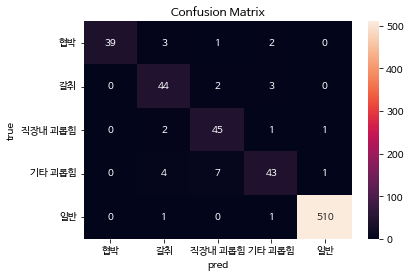

30번째 모델 경우의 수 : ['bert-base.csv', 'kogpt2-base-v2.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 29개
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        45
           1       0.81      0.90      0.85        49
           2       0.82      0.92      0.87        49
           3       0.84      0.78      0.81        55
           4       1.00      1.00      1.00       512

    accuracy                           0.96       710
   macro avg       0.89      0.89      0.89       710
weighted avg       0.96      0.96      0.96       710



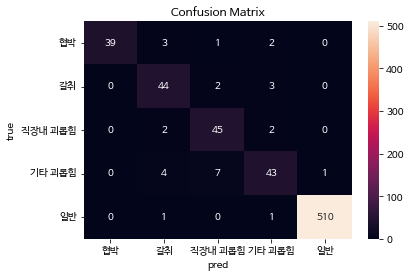

In [ ]:
unique_case = [total_case[0]]
for idx, case in enumerate(total_case):
  # 레이블 별 평균 점수 산출
  case = list(set(case))
  label_score_list = []
  for key in case:
    label_score_list.append(csv_dic[key].iloc[:,-5:].to_numpy())
  label_score_list = np.array(label_score_list)


  score_average = np.average(label_score_list, axis = 0)
  soft_voting = np.argmax(score_average, axis = -1)

  # 정답값과 예측값을 구하며 서로 맞지 않는 경우의 수도 구함
  y_pred = soft_voting.tolist()
  y_test = csv_dic[key_list[0]]["y_test"].tolist()
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]

  sorted_case = sorted(case)

  if len(false_list) <= 29 and sorted_case not in unique_case:
    unique_case += [sorted_case]
    print(f"{idx+1}번째 모델 경우의 수 : {case}")
    clf_score(y_test, y_pred)

    # 잘못 예측한 케이스가 담긴 데이터셋
    x_test = csv_dic[key_list[0]]["x_test"]
    false_score_dataset = pd.DataFrame(score_average)
    false_score_dataset.add_prefix("label_")

    false_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_true":y_test})
    total_dataset = pd.concat([false_dataset, false_score_dataset], axis = 1)

    total_dataset = total_dataset.iloc[false_list, :]

In [ ]:
for i in range(len(total_dataset)):
  sentence = total_dataset.iloc[i, 0]
  prediction = total_dataset.iloc[i, 1]
  real = total_dataset.iloc[i, 2]
  print(f"예측 분류 : {prediction}")
  print(f"실제 분류 : {real}")
  print(sentence)
  print("\n")

In [ ]:
false_dataset.to_excel("./오분류예제.xlsx")

## Translate - Interpret - XAI

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun')

data_path = "../../data/sample_5117.csv" # 학습 데이터 위치
load = DataLoad(data_path)
x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
class
0      896
1      981
2      979
3     1094
4    10234
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  class                                       conversation
0           0      0  지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1           1      0  길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2           2      3  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3           3      1  어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4           4      1  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
x_train 개수 : 12765
y_train 개수 : 12765
x_val 개수 : 709
y_val 개수 : 709
x_test 개수 : 710
y_test 개수 : 710
훈련 데이터 레이블 비율 확인 : Counter({4: 9210, 3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({4: 512, 3: 54, 2: 49, 1: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({4: 512, 3: 55, 1: 49, 2: 49, 0: 45})


In [ ]:
from collections import defaultdict
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

model_dict = defaultdict()

#모델 불러오기 
paths = ['./model/midterm/klue-bert-base']


model =  AutoModelForSequenceClassification.from_pretrained(path, from_tf=True) 
tokenizer = AutoTokenizer.from_pretrained(path)

#다중분류 설명자 생성
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
y_test == 0

False

In [ ]:
import random

i = 3
print(i)
sample = x_test[i]
sample_label = y_test[i]
print(f"실제 레이블 : {sample_label}")

word_attributions = multiclass_explainer(sample)
html = multiclass_explainer.visualize()

3
실제 레이블 : 3


## Submission 제출

In [ ]:
import json


test_path = "/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/data/TUNiB/test.json"
with open(test_path, "r", encoding = "utf-8") as st_json:
    test = json.load(st_json)
print(f"테스트 데이터 개수 : {len(test)}")    

In [ ]:
import re
import pandas as pd
from copy import deepcopy


def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

test_set = pd.DataFrame()
test_set["text"] = pd.read_json(test_path).T["text"]
test_set.head()

In [ ]:
from glob import glob
from copy import deepcopy
from collections import Counter


# model_path = "./model/midterm/klue-bert-base"
# print(f"{model_path} 추론...")
# loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
# loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

# BERT
text_classifier = TextClassificationPipeline(
    tokenizer=pipeline.tokenizer, 
    model=pipeline.model, 
    framework='tf',
    return_all_scores=True
)

tqdm.pandas()
tmp = test_set["text"].progress_apply(lambda x : text_classifier(x))
tmp = tmp.apply(lambda x : x[0])
tmp = tmp.apply(lambda y : list(map(lambda x : x["score"], y)))
test_set["class"] = tmp
test_set["label_class"] = test_set["class"].apply(lambda x : np.argmax(x))
Counter(test_set["class"].apply(lambda x : np.argmax(x)))

In [ ]:
# GPT
test_set2 = deepcopy(test_set["text"])
test_set2 = pd.DataFrame({"text": test_set2})
input_ids = []
for example in tqdm(test_set2["text"]):
    bos_token = [pipeline.tokenizer.bos_token]
    eos_token = [pipeline.tokenizer.eos_token]
    tokens = bos_token + pipeline.tokenizer.tokenize(example) + eos_token
    input_id = pipeline.tokenizer.convert_tokens_to_ids(tokens)
    input_ids.append(input_id)

max_seq_len = max(map(lambda x : len(x), input_ids))
input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                          value = pipeline.tokenizer.pad_token_id, 
                          padding='post')

tmp = pipeline.model.predict(input_ids)
test_set2["class"] = tmp.tolist()
test_set2["label_class"] = test_set2["class"].apply(lambda x : np.argmax(x))
Counter(test_set2["class"].apply(lambda x : np.argmax(x)))

100%|██████████| 500/500 [00:00<00:00, 1169.59it/s]


Counter({0: 107, 1: 99, 2: 117, 3: 115, 4: 62})

In [ ]:
concat_class = np.array([list(test_set["class"]), list(test_set2["class"])])
soft_voting = np.average(concat_class, axis = 0)
soft_voting_label = np.argmax(soft_voting, axis = 1)
Counter(soft_voting_label)

Counter({0: 97, 1: 108, 2: 118, 3: 121, 4: 56})

## Conclusion

|데이터|모델|에폭|성능|참고|
|-|-|-|-|-|
|sns, kor 데이터 5117개|BERT|1|Counter({0: 71, 1: 138, 2: 125, 3: 96, 4: 70})|base|
|sns, kor 데이터 5117개|BERT|3|Counter({0: 89, 1: 130, 2: 110, 3: 102, 4: 69})|학습률 스케줄러 lr : 0.5|
|sns, kor 데이터 5117개|GPT|5|Counter({0: 100, 1: 115, 2: 120, 3: 112, 4: 53})|학습률 스케줄러 lr : 0.2|
|sns, kor 데이터 5117개|BERT|5|Counter({0: 98, 1: 111, 2: 109, 3: 118, 4: 64})|학습률 스케줄러 lr : 0.2 |
|sns, kor 데이터 5117개|BERT|4|Counter({0: 95, 1: 114, 2: 114, 3: 123, 4: 54})|학습률 스케줄러 lr : 0.2 </br> EarlyStopping|
|sns, kor 데이터 5117개|GPT </br> BERT|5|Counter({0: 99, 1: 107, 2: 113, 3: 118, 4: 63})|학습률 스케쥴러 lr : 0.2|
|sns, kor 데이터 5117개|GPT </br> BERT|5|Counter({0: 97, 1: 108, 2: 118, 3: 121, 4: 56})|학습률 스케쥴러 lr : 0.2 </br> EarlyStopping|



In [ ]:
# from collections import Counter

# # LSTM 모델
# lstm_path = "./model/midterm/LSTM/LSTM.h5"
# lstm_loaded_model = tf.keras.models.load_model(lstm_path)

# spm_path = "./bpe_10000_train_spm.model"
# s = spm.SentencePieceProcessor()
# s.Load(spm_path)

# tokened_values = [s.EncodeAsIds(value) for value in test_set["text"]]
# max_length = 439
# padded_values = pad_sequences(tokened_values, maxlen = max_length)

# lstm_pred = lstm_loaded_model.predict(padded_values)
# Counter(np.argmax(lstm_pred, axis = -1))


# gpt_token = [pipeline.tokenizer.tokenize(text) for text in test_set["text"]]
# input_ids = []
# for example in test_set["text"]:
#     bos_token = [pipeline.tokenizer.bos_token]
#     eos_token = [pipeline.tokenizer.eos_token]
#     tokens = bos_token + pipeline.tokenizer.tokenize(example) + eos_token
#     input_id = pipeline.tokenizer.convert_tokens_to_ids(tokens)
#     input_ids.append(input_id)

# max_seq_len = 388
# input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
#                           value = pipeline.tokenizer.pad_token_id, 
#                           padding='post')
# gpt_pred = pipeline.model.predict(input_ids)
# Counter(np.argmax(gpt_pred, axis = -1))

# bucket_pred_score = [np.array(list(test_set["class"])), lstm_pred, gpt_pred]
# total_pred_score = np.array(bucket_pred_score)
# average_score = np.average(total_pred_score, axis = 0)
# soft_voting_label = np.argmax(average_score, axis = -1)

# print(Counter(soft_voting_label))
# pred_dataset = pd.DataFrame(test_set["text"])
# pred_dataset["class"] = soft_voting_label
# pred_dataset

Counter({0: 66, 1: 104, 2: 108, 3: 214, 4: 8})

In [ ]:
indexes = pred_dataset.index

answer = defaultdict()
tmp = defaultdict()
for idx, case in enumerate(indexes):
  tmp = str(0) + str(pred_dataset["class"][idx])
  answer[case] = dict({"class":tmp})
answer = dict(answer)
list(answer.items())[:10]

[('t_000', {'class': '01'}),
 ('t_001', {'class': '02'}),
 ('t_002', {'class': '02'}),
 ('t_003', {'class': '03'}),
 ('t_004', {'class': '03'}),
 ('t_005', {'class': '00'}),
 ('t_006', {'class': '00'}),
 ('t_007', {'class': '01'}),
 ('t_008', {'class': '03'}),
 ('t_009', {'class': '01'})]

In [ ]:
with open('./submission/lstm_gpt_bert.json', 'w') as fp:
    json.dump(answer, fp)